In [ ]:
# check GPU 
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
# import libraries
import os                                                
import numpy as np
import pandas as pd
import cv2                                              
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.applications.vgg19 import VGG19, preprocess_input
from keras.callbacks import EarlyStopping
from keras.layers import (BatchNormalization, 
                                     Dense, 
                                     Dropout, 
                                     Flatten, 
                                     Input,
                                     RandomFlip, 
                                     RandomRotation,
                                     RandomTranslation,
                                     RandomZoom)
from keras.models import Model, Sequential
from matplotlib import pyplot as plt

In [ ]:
# load dataset with Kaggle API
from google.colab import files
files.upload()

In [ ]:
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d ikarus777/best-artworks-of-all-time

100% 2.29G/2.29G [02:07<00:00, 20.4MB/s]
100% 2.29G/2.29G [02:07<00:00, 19.2MB/s]


In [ ]:
!unzip "/content/best-artworks-of-all-time.zip" -d "/content"

In [ ]:
artists = pd.read_csv("artists.csv")
artists.head()

,id,name,years,genre,nationality,bio,wikipedia,paintings
0,0,Amedeo Modigliani,1884 - 1920,Expressionism,Italian,Amedeo Clemente Modigliani (Italian pronunciat...,http://en.wikipedia.org/wiki/Amedeo_Modigliani,193
1,1,Vasiliy Kandinskiy,1866 - 1944,"Expressionism,Abstractionism",Russian,Wassily Wassilyevich Kandinsky (Russian: Васи́...,http://en.wikipedia.org/wiki/Wassily_Kandinsky,88
2,2,Diego Rivera,1886 - 1957,"Social Realism,Muralism",Mexican,Diego María de la Concepción Juan Nepomuceno E...,http://en.wikipedia.org/wiki/Diego_Rivera,70
3,3,Claude Monet,1840 - 1926,Impressionism,French,Oscar-Claude Monet (; French: [klod mɔnɛ]; 14 ...,http://en.wikipedia.org/wiki/Claude_Monet,73
4,4,Rene Magritte,1898 - 1967,"Surrealism,Impressionism",Belgian,René François Ghislain Magritte (French: [ʁəne...,http://en.wikipedia.org/wiki/René_Magritte,194


In [ ]:
# grab artist names from the csv file -> number of classes ~ number of artists
artist_names = artists["name"].to_dict()
reversed_artist_names = {y : x for x,y in artist_names.items()}
print(reversed_artist_names)
n_classes = len(artist_names)
n_classes

{'Amedeo Modigliani': 0, 'Vasiliy Kandinskiy': 1, 'Diego Rivera': 2, 'Claude Monet': 3, 'Rene Magritte': 4, 'Salvador Dali': 5, 'Edouard Manet': 6, 'Andrei Rublev': 7, 'Vincent van Gogh': 8, 'Gustav Klimt': 9, 'Hieronymus Bosch': 10, 'Kazimir Malevich': 11, 'Mikhail Vrubel': 12, 'Pablo Picasso': 13, 'Peter Paul Rubens': 14, 'Pierre-Auguste Renoir': 15, 'Francisco Goya': 16, 'Frida Kahlo': 17, 'El Greco': 18, 'Albrecht Dürer': 19, 'Alfred Sisley': 20, 'Pieter Bruegel': 21, 'Marc Chagall': 22, 'Giotto di Bondone': 23, 'Sandro Botticelli': 24, 'Caravaggio': 25, 'Leonardo da Vinci': 26, 'Diego Velazquez': 27, 'Henri Matisse': 28, 'Jan van Eyck': 29, 'Edgar Degas': 30, 'Rembrandt': 31, 'Titian': 32, 'Henri de Toulouse-Lautrec': 33, 'Gustave Courbet': 34, 'Camille Pissarro': 35, 'William Turner': 36, 'Edvard Munch': 37, 'Paul Cezanne': 38, 'Eugene Delacroix': 39, 'Henri Rousseau': 40, 'Georges Seurat': 41, 'Paul Klee': 42, 'Piet Mondrian': 43, 'Joan Miro': 44, 'Andy Warhol': 45, 'Paul Gaugui

50

In [ ]:
# mitigate class imbalance by using class weights
artists["class_weights"] = artists["paintings"].sum() / (artists.shape[0] * artists['paintings'])
class_weights = artists["class_weights"].to_dict()
artists.head()

,id,name,years,genre,nationality,bio,wikipedia,paintings,class_weights
0,0,Amedeo Modigliani,1884 - 1920,Expressionism,Italian,Amedeo Clemente Modigliani (Italian pronunciat...,http://en.wikipedia.org/wiki/Amedeo_Modigliani,193,0.875233
1,1,Vasiliy Kandinskiy,1866 - 1944,"Expressionism,Abstractionism",Russian,Wassily Wassilyevich Kandinsky (Russian: Васи́...,http://en.wikipedia.org/wiki/Wassily_Kandinsky,88,1.919545
2,2,Diego Rivera,1886 - 1957,"Social Realism,Muralism",Mexican,Diego María de la Concepción Juan Nepomuceno E...,http://en.wikipedia.org/wiki/Diego_Rivera,70,2.413143
3,3,Claude Monet,1840 - 1926,Impressionism,French,Oscar-Claude Monet (; French: [klod mɔnɛ]; 14 ...,http://en.wikipedia.org/wiki/Claude_Monet,73,2.313973
4,4,Rene Magritte,1898 - 1967,"Surrealism,Impressionism",Belgian,René François Ghislain Magritte (French: [ʁəne...,http://en.wikipedia.org/wiki/René_Magritte,194,0.870722


In [ ]:
print(os.listdir("resized/resized")[:10])
print(os.path.join("resized/resized", "Titian"))

['Mikhail_Vrubel_170.jpg', 'Henri_de_Toulouse-Lautrec_31.jpg', 'Camille_Pissarro_4.jpg', 'Vasiliy_Kandinskiy_70.jpg', 'Paul_Klee_12.jpg', 'Vincent_van_Gogh_598.jpg', 'Titian_87.jpg', 'Andrei_Rublev_12.jpg', 'Andy_Warhol_84.jpg', 'Pablo_Picasso_434.jpg']
resized/resized/Titian


In [ ]:
 # create an array of images and labels using openCV 
IMG_DIM = 224
image_files = os.listdir("resized/resized")    
image_directory = "resized/resized"        # list directory

img_list = []
label_list = []



for file in image_files:
  index = file.rfind("_")
  name = file[:index].replace("_"," ")
  if name in reversed_artist_names.keys():
    label_list.append(reversed_artist_names[name])
    img = cv2.imread(os.path.join(image_directory, file))
    img = cv2.resize(img, (IMG_DIM, IMG_DIM))
    img_list.append(img)

images = np.asarray(img_list)
labels = np.asarray(label_list)

Henri de Toulouse-Lautrec


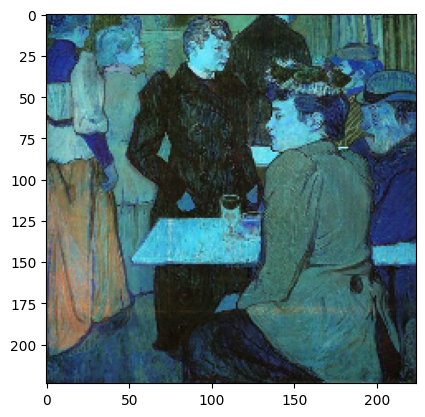

In [ ]:
# sanity check
plt.imshow(images[1])
print(artist_names[labels[1]])

Vincent van Gogh


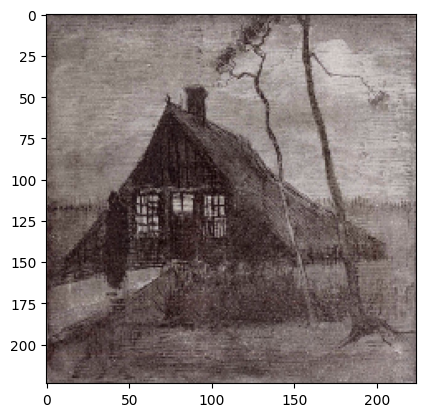

In [ ]:
plt.imshow(images[16])
print(artist_names[labels[16]])

In [ ]:
# split into test, train, validate
X, X_test, y, y_test = train_test_split(images, 
                                        labels, 
                                        test_size = 0.1, 
                                        random_state = 13)

X_train, X_val, y_train, y_val = train_test_split(X, 
                                                  y, 
                                                  test_size = 1/9, 
                                                  random_state = 13)

In [ ]:
# random augmentations performed on the dataset to enable better learning
data_augmentation = Sequential([
    RandomFlip('horizontal'),
    RandomFlip('vertical'),
    RandomRotation(0.2),
    RandomZoom(0.1),
    RandomTranslation(0.1, 0.1),
])

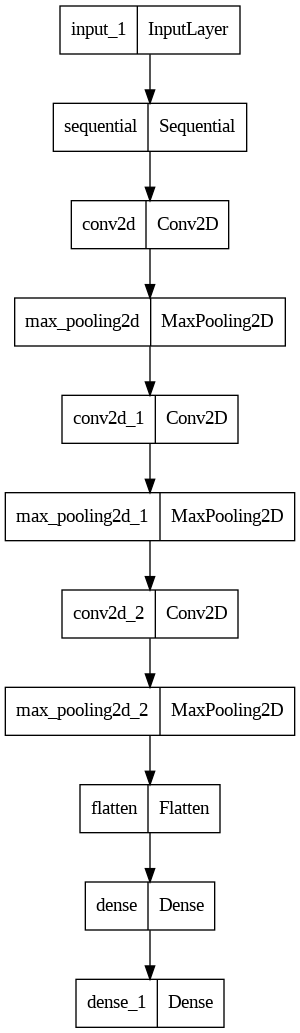

In [ ]:
# Keras functional API ~ a model trained from scratch

inputs = Input(shape=(IMG_DIM, IMG_DIM, 3))
processingLayer1 = data_augmentation(inputs)

ConvLayer1 = keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer="glorot_uniform", input_shape=(IMG_DIM, IMG_DIM, 3))(processingLayer1)
MaxPoolLayer1 = keras.layers.MaxPooling2D((2, 2))(ConvLayer1)

ConvLayer2 = keras.layers.Conv2D(128, (3, 3), activation='relu')(MaxPoolLayer1)
MaxPoolLayer2 = keras.layers.MaxPooling2D((2, 2))(ConvLayer2)

ConvLayer3 = keras.layers.Conv2D(64, (3, 3), activation='relu')(MaxPoolLayer2)
MaxPoolLayer3 = keras.layers.MaxPooling2D((2, 2))(ConvLayer3)

flattenLayer = Flatten()(MaxPoolLayer3)
denseLayer = Dense(128, activation='relu')(flattenLayer)

outputLayer = Dense(n_classes, activation="softmax")(denseLayer)
model = Model(inputs=inputs, outputs=outputLayer, name="ArtWorkModel")

tf.keras.utils.plot_model(model, "my_first_model.png")

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=30, 
                    class_weight = class_weights,
                    batch_size = 64,
                    validation_data=(X_val, y_val))

Epoch 1/30
101/101 [==============================] - 69s 472ms/step - loss: 10.7466 - accuracy: 0.0542 - val_loss: 3.8968 - val_accuracy: 0.0785
Epoch 2/30
101/101 [==============================] - 41s 406ms/step - loss: 3.9698 - accuracy: 0.0987 - val_loss: 3.8744 - val_accuracy: 0.0847
Epoch 3/30
101/101 [==============================] - 40s 392ms/step - loss: 3.9557 - accuracy: 0.0763 - val_loss: 3.8826 - val_accuracy: 0.0834
Epoch 4/30
101/101 [==============================] - 41s 405ms/step - loss: 4.0152 - accuracy: 0.0794 - val_loss: 3.8869 - val_accuracy: 0.0448
Epoch 5/30
101/101 [==============================] - 41s 404ms/step - loss: 3.9539 - accuracy: 0.0431 - val_loss: 3.9000 - val_accuracy: 0.0436
Epoch 6/30
101/101 [==============================] - 41s 405ms/step - loss: 3.9560 - accuracy: 0.0148 - val_loss: 3.8804 - val_accuracy: 0.0423
Epoch 7/30
101/101 [==============================] - 41s 405ms/step - loss: 3.9482 - accuracy: 0.0343 - val_loss: 3.8831 - val_a

In [ ]:
model.evaluate(X_test, y_test)

26/26 [==============================] - 4s 65ms/step - loss: 3.8737 - accuracy: 0.0112


[3.873716354370117, 0.01120796985924244]

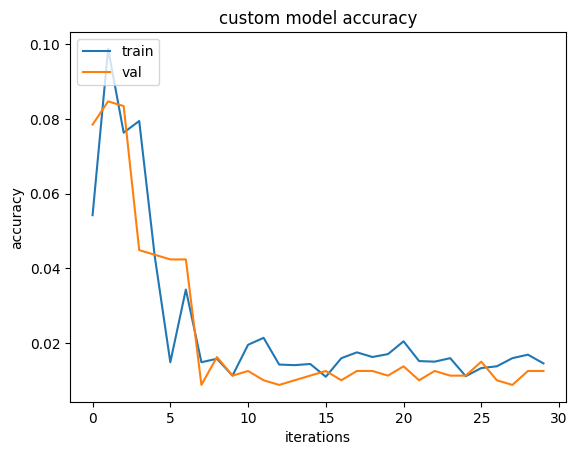

In [ ]:
# accuracy v loss plots

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('custom model accuracy')
plt.ylabel('accuracy')
plt.xlabel('iterations')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
### PRETRAINED MODELS - using transfer learning to utilise very deep networks trained on very large datasets ###
## VGG16
# trained without data augmentation
BASE_MODEL_TRAINABLE=False


base_model = tf.keras.applications.VGG16(include_top = False,
                   weights = "imagenet",
                   classes = n_classes, 
                   input_shape = (IMG_DIM, IMG_DIM, 3))

base_model.trainable = BASE_MODEL_TRAINABLE
base_model.summary()

In [ ]:
prediction = Sequential([
    Flatten(),
    Dense(512),
    BatchNormalization(),
    Dropout(0.1),
    Dense(512),
    Dense(n_classes, activation = 'softmax'),
])

inputs = Input(shape=(IMG_DIM, IMG_DIM, 3))
processing1 = preprocess_input(inputs)
processing1 = base_model(processing1)
outputs = prediction(processing1)
model = Model(inputs, outputs)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()


epochs = 10
batch_size = 64


history = model.fit(X_train,
                    y_train,
                    validation_data = (X_val, y_val),
                    epochs = epochs,
                    class_weight = class_weights,
                    batch_size = batch_size)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 sequential_1 (Sequential)   (None, 50)                13135922  
                                                                 
Total params: 27,850,610
Trainable params: 13,134,898
Non-trainable params: 14,715,712
________________________________________

In [ ]:
model.evaluate(X_test, y_test)

26/26 [==============================] - 9s 163ms/step - loss: 1.7667 - accuracy: 0.6476


[1.7667230367660522, 0.6475716233253479]

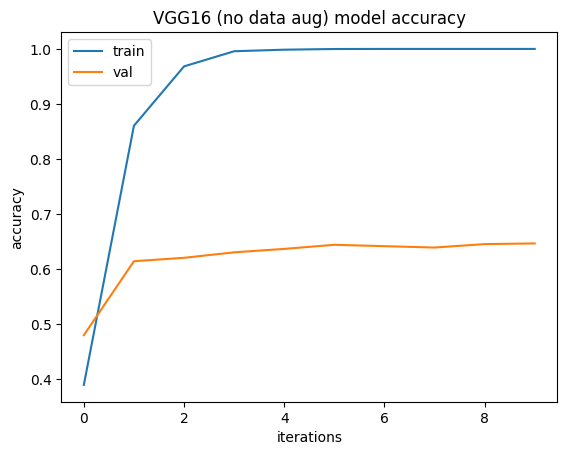

In [ ]:
# accuracy v loss plots

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('VGG16 (no data aug) model accuracy')
plt.ylabel('accuracy')
plt.xlabel('iterations')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# VGG16 with augmentation applied

prediction = Sequential([
    Flatten(),
    Dense(512),
    BatchNormalization(),
    Dropout(0.1),
    Dense(512),
    Dense(n_classes, activation = 'softmax'),
])

inputs = Input(shape=(IMG_DIM, IMG_DIM, 3))
processing1 = data_augmentation(inputs)
processing1 = preprocess_input(inputs)
processing1 = base_model(processing1)
outputs = prediction(processing1)
model = Model(inputs, outputs)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(X_train,
                    y_train,
                    validation_data = (X_val, y_val),
                    epochs = 10,
                    class_weight = class_weights,
                    batch_size = 128)


model.evaluate(X_test, y_test)

Epoch 1/10
51/51 [==============================] - 50s 657ms/step - loss: 2.9710 - accuracy: 0.3855 - val_loss: 3.7183 - val_accuracy: 0.4421
Epoch 2/10
51/51 [==============================] - 32s 625ms/step - loss: 0.3626 - accuracy: 0.8542 - val_loss: 2.0963 - val_accuracy: 0.5803
Epoch 3/10
51/51 [==============================] - 32s 633ms/step - loss: 0.0759 - accuracy: 0.9670 - val_loss: 1.7788 - val_accuracy: 0.6239
Epoch 4/10
51/51 [==============================] - 32s 637ms/step - loss: 0.0236 - accuracy: 0.9897 - val_loss: 1.6900 - val_accuracy: 0.6227
Epoch 5/10
51/51 [==============================] - 32s 634ms/step - loss: 0.0100 - accuracy: 0.9978 - val_loss: 1.6775 - val_accuracy: 0.6252
Epoch 6/10
51/51 [==============================] - 32s 635ms/step - loss: 0.0056 - accuracy: 0.9995 - val_loss: 1.6712 - val_accuracy: 0.6289
Epoch 7/10
51/51 [==============================] - 31s 601ms/step - loss: 0.0041 - accuracy: 0.9998 - val_loss: 1.6847 - val_accuracy: 0.6264

[1.762451171875, 0.6301369667053223]

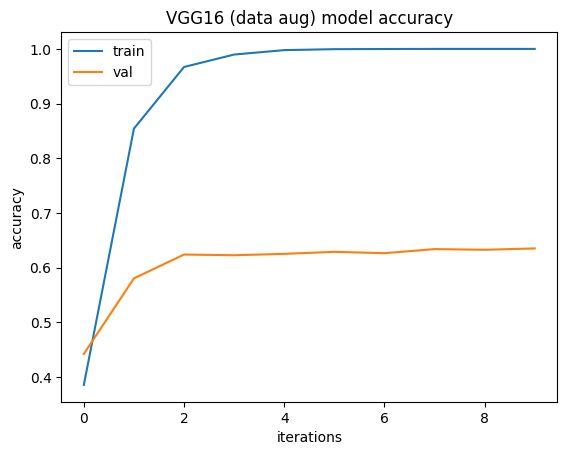

In [ ]:
# accuracy v loss plots

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('VGG16 (data aug) model accuracy')
plt.ylabel('accuracy')
plt.xlabel('iterations')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
## ResNet 50

base_model = tf.keras.applications.ResNet50V2(include_top = False,
                   weights = "imagenet",
                   classes = n_classes, 
                   input_shape = (IMG_DIM, IMG_DIM, 3))

base_model.trainable = BASE_MODEL_TRAINABLE
base_model.summary()

In [ ]:
prediction = Sequential([
    Flatten(),
    Dense(512),
    BatchNormalization(),
    Dropout(0.1),
    Dense(512),
    Dense(n_classes, activation = 'softmax'),
])




inputs = Input(shape=(IMG_DIM, IMG_DIM, 3))
processing1 = preprocess_input(inputs)
processing1 = base_model(processing1)
outputs = prediction(processing1)
model = Model(inputs, outputs)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

In [ ]:
epochs = 10
batch_size = 64


history = model.fit(X_train,
                    y_train,
                    validation_data = (X_val, y_val),
                    epochs = epochs,
                    class_weight = class_weights,
                    batch_size = batch_size)

Epoch 1/10
101/101 [==============================] - 33s 236ms/step - loss: 4.3673 - accuracy: 0.0610 - val_loss: 4.9611 - val_accuracy: 0.0760
Epoch 2/10
101/101 [==============================] - 19s 192ms/step - loss: 3.4176 - accuracy: 0.1427 - val_loss: 3.8473 - val_accuracy: 0.0834
Epoch 3/10
101/101 [==============================] - 20s 194ms/step - loss: 2.8596 - accuracy: 0.2271 - val_loss: 3.9988 - val_accuracy: 0.0971
Epoch 4/10
101/101 [==============================] - 19s 189ms/step - loss: 2.2516 - accuracy: 0.3328 - val_loss: 4.1353 - val_accuracy: 0.0909
Epoch 5/10
101/101 [==============================] - 19s 192ms/step - loss: 1.7026 - accuracy: 0.4414 - val_loss: 4.1836 - val_accuracy: 0.1719
Epoch 6/10
101/101 [==============================] - 20s 197ms/step - loss: 1.3105 - accuracy: 0.5357 - val_loss: 4.4692 - val_accuracy: 0.1494
Epoch 7/10
101/101 [==============================] - 19s 190ms/step - loss: 0.9948 - accuracy: 0.6167 - val_loss: 4.0782 - val_ac

In [ ]:
model.evaluate(X_test, y_test)

26/26 [==============================] - 4s 111ms/step - loss: 5.2838 - accuracy: 0.1631


[5.283787250518799, 0.1631382256746292]

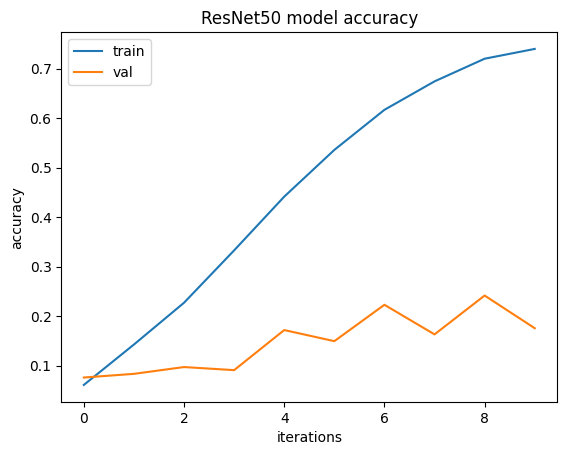

In [ ]:
# accuracy v loss plots

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('ResNet50 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('iterations')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# ConvNeXt XLarge model
base_model = tf.keras.applications.ConvNeXtXLarge(
    model_name="convnext_xlarge",
    include_top=False,
    include_preprocessing=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=50,
    classifier_activation="softmax",
)

base_model.trainable = BASE_MODEL_TRAINABLE
base_model.summary()

In [ ]:
prediction = Sequential([
    Flatten(),
    Dense(512),
    BatchNormalization(),
    Dropout(0.1),
    Dense(512),
    Dense(n_classes, activation = 'softmax'),
])




inputs = Input(shape=(IMG_DIM, IMG_DIM, 3))
processing1 = preprocess_input(inputs)
processing1 = base_model(processing1)
outputs = prediction(processing1)
model = Model(inputs, outputs)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(X_train,
                    y_train,
                    validation_data = (X_val, y_val),
                    epochs = 10,
                    class_weight = class_weights,
                    batch_size = 64)

Epoch 1/10
101/101 [==============================] - 448s 4s/step - loss: 3.0492 - accuracy: 0.3978 - val_loss: 2.2035 - val_accuracy: 0.4782
Epoch 2/10
101/101 [==============================] - 368s 4s/step - loss: 0.4023 - accuracy: 0.8407 - val_loss: 1.5097 - val_accuracy: 0.6115
Epoch 3/10
101/101 [==============================] - 368s 4s/step - loss: 0.1372 - accuracy: 0.9475 - val_loss: 1.4116 - val_accuracy: 0.6501
Epoch 4/10
101/101 [==============================] - 368s 4s/step - loss: 0.0300 - accuracy: 0.9866 - val_loss: 1.2768 - val_accuracy: 0.6899
Epoch 5/10
101/101 [==============================] - 368s 4s/step - loss: 0.0062 - accuracy: 0.9983 - val_loss: 1.2294 - val_accuracy: 0.6986
Epoch 6/10
101/101 [==============================] - 368s 4s/step - loss: 0.0021 - accuracy: 0.9997 - val_loss: 1.2372 - val_accuracy: 0.6974
Epoch 7/10
101/101 [==============================] - 368s 4s/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 1.2217 - val_accuracy: 0.7123

In [ ]:
model.evaluate(X_test, y_test)

26/26 [==============================] - 51s 2s/step - loss: 1.1020 - accuracy: 0.7447


[1.1020450592041016, 0.7447073459625244]

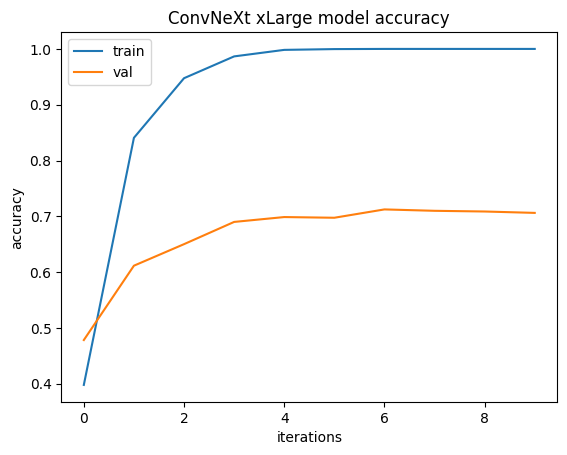

In [ ]:
# accuracy v loss plots

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('ConvNeXt xLarge model accuracy')
plt.ylabel('accuracy')
plt.xlabel('iterations')
plt.legend(['train', 'val'], loc='upper left')
plt.show()